# Creating a New Thorn -- WaveEqn
---

In this tutorial we will walk through the process of creating a new thorn from scratch. As a new user, you may be content at first to run simulations that have already been assembled by someone else (such as the gallery examples). Beyond that you may want to assemble your own simulation using existing thorns. However at some point you may have an application that involves a step, or calculation, or algorithm, that no existing thorn performs. At that point, you need to write your own thorn to carry out that subroutine. The case study we will consider here is to create a thorn to evolve the standard wave equation.

Let's start with a brief overview of what a thorn needs to include:

* a Cactus thorn must have a name.
* a Cactus thorn must live in an arrangement.
* a Cactus thorn must have four ccl (Cactus Configuration Language) files:
 * `interface.ccl`
 * `schedule.ccl`
 * `param.ccl`
 * `configuration.ccl`
* a Cactus thorn must have a `src` directory
* a Cactus thorn must have a `make.code.defn` file in that source directory

The above thorn files and directories should reside in `Cactus/arrangements/ArrangementName/ThornName/`.

In [1]:
# this allows you to use "cd" in cells to change directories instead of requiring "%cd"
%automagic on
# Keeps display scrolled to the bottom
import scrolldown
# override IPython's default %%bash to not buffer all output
from IPython.core.magic import register_cell_magic
@register_cell_magic
def bash(line, cell): get_ipython().system(cell)


Automagic is ON, % prefix IS NOT needed for line magics.


<IPython.core.display.Javascript object>

## 0. Preliminaries

First let's create a variable for the Cactus directory on your machine and then move to that directory (in case it is not already the working directory).

In [2]:
## Linux example:
#cactus_dir='/home/ejwest/ETK/Cactus'

## Windows example:
#cactus_dir='C:\\Users\\EJWest\\ETK\\Cactus'
import os
home_dir = os.environ["HOME"]

## fill in the path to your Cactus directory
cactus_dir=os.path.join(home_dir,'Cactus') #<-- COMPLETE THIS LINE!

In [3]:
%cd {cactus_dir}

/home/sbrand3/Cactus


Next let's specify the name and arrangement of the thorn we want to make. Here we are creating a thorn to evolve the wave equation, so we will name it `WaveEqn` and place it in the arrangment `Tests`. As a result, the files we create below will be located in `Cactus/arrangements/Tests/WaveEqn`. The following block creates some environment variables that will be used below. 

In [4]:
## Define some basic parameters describing a new thorn
thorn_pars = {
   "thorn_name" : "WaveEqn",
   "arrangement_name" : "Tests",
 }

## Define environment variables ARR and THORN to be used
## throughout the rest of the tutorial
import os
os.environ["ARR"]=thorn_pars["arrangement_name"]
os.environ["THORN"]=thorn_pars["thorn_name"]

This next command is only needed if you want to start over. Uncomment and run this line to delete the thorn you created and start over.

In [5]:
#%rm -rf arrangements/$ARR/$THORN

Next we create the thorn directory and sub-directories.

In [6]:
## The equivalent of mkdir -p
def create_dir(dir):
    print("Ensuring directory '"+dir+"'")
    os.makedirs(dir, exist_ok=True)
        
## Create the thorn directory inside the Cactus source tree
arrangement_dir = os.path.join(cactus_dir, "arrangements", thorn_pars["arrangement_name"])
thorn_dir = os.path.join(arrangement_dir, thorn_pars["thorn_name"])
create_dir(thorn_dir)

## Create the source directory
src_dir = os.path.join(thorn_dir, "src")
create_dir(src_dir)

## Other dirs and files not strictly needed
## for compiling and running Cactus.
test_dir = os.path.join(thorn_dir, "test")
create_dir(test_dir)
par_dir = os.path.join(thorn_dir, "par")
create_dir(par_dir)
doc_dir = os.path.join(thorn_dir, "doc")
create_dir(doc_dir)

Ensuring directory '/home/sbrand3/Cactus/arrangements/Tests/WaveEqn'
Ensuring directory '/home/sbrand3/Cactus/arrangements/Tests/WaveEqn/src'
Ensuring directory '/home/sbrand3/Cactus/arrangements/Tests/WaveEqn/test'
Ensuring directory '/home/sbrand3/Cactus/arrangements/Tests/WaveEqn/par'
Ensuring directory '/home/sbrand3/Cactus/arrangements/Tests/WaveEqn/doc'


Now move to the thorn directory that we just created and examine its contents. All that appears so far are the sub-directories that we created above.

In [7]:
print()
print('Directory contents:')
%ls {thorn_dir}


Directory contents:
doc/  par/  src/  test/


We're finally ready to start creating the files that make up the thorn. We can write the contents of a notebook cell to a file by using the `%%writefile` command. A command that begins with `%%` is called a "cell-magic", since it operates on the entire content of a cell (as opposed to a "line-magic", prefixed by `%`, which only operates on the same line). We will use the `%%writefile` cell-magic repeatedly throughout this tutorial to create files. Of course you could also create the files outside of the notebook, using your favorite editor. Working in the notebook is just a shortcut. 

As a first application of the `%%writefile` magic, let's create a README file for our thorn. Below is the standard template for that. Change the names and email addresses to your own and then execute the cell.

In [8]:
%%writefile {thorn_dir}/README
Author(s)    : Eric J. West <ewest@d.umn.edu>
Maintainer(s): Eric J. West <ewest@d.umn.edu>
Licence      : BSD
--------------------------------------------------------------------------

1. Purpose

Basic implementation evolving the standard 3D wave equation.

Writing /home/sbrand3/Cactus/arrangements/Tests/WaveEqn/README


Now re-examine the contents of the thorn directory. The README file we just created should be listed.

In [9]:
%ls {thorn_dir}

doc/  par/  README  src/  test/


## 1. Source code and make file

In this section we will create the contents of the `src` subdirectory. This includes any source code (written in either C++ or Fortran) and a make file.

The equation we want to solve is the standard (linear) 3D wave equation. Let's call the dependent variable $U(t,x,y,z)$. In terms of Cartesian coordinates, the wave equation is written as

\begin{align}
  \partial_{t}^{2}U
  = \partial_{x}^{2}U + \partial_{y}^{2}U + \partial_{z}^{2}U,
\end{align}

where units have been chosen so that the wave speed $c=1$. In this simulation, we will use the method of lines (implemented by the MoL thorn). This requires that the equations are reduced to first-order as follows

\begin{align}
  & \partial_{t}U = K \\
  & \partial_{t}K 
  = \partial_{x}^{2}U + \partial_{y}^{2}U + \partial_{z}^{2}U.
\end{align}

What is passed to the MoL thorn is the right-hand side (RHS) for each variable, which here means the RHS for $U$ and $K$. Using centered finite-differences gives 

\begin{align}
  & (\text{RHS for }U) = K \\
  & \\
  & (\text{RHS for }K) 
  = \frac{U^{n}_{i+1,j,k} + U^{n}_{i-1,j,k} - 2U^{n}_{i,j,k}}{(\Delta{x})} 
  + \frac{U^{n}_{i,j+1,k} + U^{n}_{i,j-1,k} - 2U^{n}_{i,j,k}}{(\Delta{y})} 
  + \frac{U^{n}_{i,j,k+1} + U^{n}_{i,j,k-1} - 2U^{n}_{i,j,k}}{(\Delta{z})}
\end{align}

For simplicity we will seek solutions with boundary conditions

\begin{align}
  & \partial_{t}K(t,0,y,z) = \partial_{t}K(t,L_{x},y,z) = 0 \\
  & \partial_{t}K(t,x,0,z) = \partial_{t}K(t,x,L_{y},z) = 0 \\
  & \partial_{t}K(t,x,y,0) = \partial_{t}K(t,x,y,L_{z}) = 0
\end{align}

We will take the initial configuration to be a Gaussian

\begin{align}
  U(0,x,y,z) = e^{-(x^2 + y^2)}
\end{align}

The equations, boundary conditions, and initial condition are implemented in the following source code files.

The following file registers our variables with the MoL thorn.

In [10]:
%%writefile {thorn_dir}/src/mol_register.c
#include <cctk.h>
#include <cctk_Arguments.h>
#include <cctk_Parameters.h>

// Register variables with MoL
void WaveEqn_MoLRegister(CCTK_ARGUMENTS)
{
  DECLARE_CCTK_ARGUMENTS_WaveEqn_MoLRegister;  // Declare all grid functions from interface.ccl
  CCTK_INT ierr = 0, group, rhs;

  // Look up the group index of the evol_group
  group = CCTK_GroupIndex ("WaveEqn::evol_group");
  
  // Look up the group index of the rhs_group
  rhs = CCTK_GroupIndex ("WaveEqn::rhs_group");

  if (CCTK_IsFunctionAliased ("MoLRegisterEvolvedGroup"))
  {
    // *** KEY STEP! *** Tell MoL what we variables
    // we are evolving and what the rhs variables are.
    ierr += MoLRegisterEvolvedGroup(group, rhs);
  }
  else
  {
    CCTK_WARN (0, "MoL function not aliased !");
    ierr++;
  }

  if (ierr)
  {
    CCTK_WARN(CCTK_WARN_ABORT, "Problems registering with MoL !");
  }
}

Writing /home/sbrand3/Cactus/arrangements/Tests/WaveEqn/src/mol_register.c


The following file initializes the solution, implementing the initial conditions.

In [11]:
%%writefile {thorn_dir}/src/init.c
#include <cctk.h>
#include <cctk_Arguments.h>
#include <cctk_Parameters.h>

// Initialize grid functions
void WaveEqn_Initialize(CCTK_ARGUMENTS)
{
  DECLARE_CCTK_ARGUMENTS_WaveEqn_Initialize;  // Declare all grid functions from interface.ccl
  DECLARE_CCTK_PARAMETERS; // Declare all parameters from param.ccl

  for (int k = 0; k < cctk_lsh[2]; k++) // loop over the z direction
  {
    for (int j = 0; j < cctk_lsh[1]; j++) // loop over the y direction
    {
      for (int i = 0; i < cctk_lsh[0]; i++) // loop over the x direction
      {
        const size_t ijk = CCTK_GFINDEX3D(cctkGH, i, j, k);
        U[ijk] = exp(-x[ijk] * x[ijk] - y[ijk] * y[ijk]);
        K[ijk] = 0.0;
      }
    }
  }
}

Writing /home/sbrand3/Cactus/arrangements/Tests/WaveEqn/src/init.c


The following file updates the RHS's at each timestep.

In [12]:
%%writefile {thorn_dir}/src/evolve.c
#include <cctk.h>
#include <cctk_Arguments.h>
#include <cctk_Parameters.h>

// Update RHS functions
void WaveEqn_RHS(CCTK_ARGUMENTS)
{
  DECLARE_CCTK_ARGUMENTS_WaveEqn_RHS;  // Declare all grid functions from interface.ccl
  DECLARE_CCTK_PARAMETERS; // Declare all parameters from param.ccl

  const int gz = cctk_nghostzones[2];
  const int gy = cctk_nghostzones[1];
  const int gx = cctk_nghostzones[0];

  const CCTK_REAL dt = CCTK_DELTA_TIME;

  const CCTK_REAL dx = CCTK_DELTA_SPACE(0);
  const CCTK_REAL dy = CCTK_DELTA_SPACE(1);
  const CCTK_REAL dz = CCTK_DELTA_SPACE(2);

  for (int k = gz; k < cctk_lsh[2] - gz; k++) // loop over the z direction
  {
    for (int j = gy; j < cctk_lsh[1] - gy; j++) // loop over the y direction
    {
      for (int i = gx; i < cctk_lsh[0] - gx; i++) // loop over the x direction
      {
        const size_t ijk = CCTK_GFINDEX3D(cctkGH, i, j, k);
        const size_t ip1jk = CCTK_GFINDEX3D(cctkGH, i + 1, j, k);
        const size_t im1jk = CCTK_GFINDEX3D(cctkGH, i - 1, j, k);
        const size_t ijp1k = CCTK_GFINDEX3D(cctkGH, i, j + 1, k);
        const size_t ijm1k = CCTK_GFINDEX3D(cctkGH, i, j - 1, k);
        const size_t ijkp1 = CCTK_GFINDEX3D(cctkGH, i, j, k + 1);
        const size_t ijkm1 = CCTK_GFINDEX3D(cctkGH, i, j, k - 1);

        const CCTK_REAL laplacian_U = (U[ip1jk] + U[im1jk] - 2 * U[ijk]) / (dx * dx)
                                    + (U[ijp1k] + U[ijm1k] - 2 * U[ijk]) / (dy * dy)
                                    + (U[ijkp1] + U[ijkm1] - 2 * U[ijk]) / (dz * dz);

        U_rhs[ijk] = K[ijk];
        K_rhs[ijk] = laplacian_U;
      }
    }
  }
}

Writing /home/sbrand3/Cactus/arrangements/Tests/WaveEqn/src/evolve.c


The following file imposes the boundary conditions at each timestep. This should be done after the interior points are updated.

In [13]:
%%writefile {thorn_dir}/src/boundary.c
#include <cctk.h>
#include <cctk_Arguments.h>
#include <cctk_Parameters.h>

// Update grid functions at boundary points
void WaveEqn_Boundary(CCTK_ARGUMENTS)
{
  DECLARE_CCTK_ARGUMENTS_WaveEqn_Boundary;  // Declare all grid functions from interface.ccl
  DECLARE_CCTK_PARAMETERS; // Declare all parameters from param.ccl

  const int gz = cctk_nghostzones[2];
  const int gy = cctk_nghostzones[1];
  const int gx = cctk_nghostzones[0];

  const CCTK_REAL dt = CCTK_DELTA_TIME;

  // Lower X Boundary
  if (cctk_bbox[0])
  {
    for (int k = 0; k < cctk_lsh[2]; k++) // loop over the z direction
    {
      for (int j = 0; j < cctk_lsh[1]; j++) // loop over the y direction
      {
        for (int i = 0; i < gx; i++) // loop over the x direction
        {
          const size_t ijk = CCTK_GFINDEX3D(cctkGH, i, j, k);
          U_rhs[ijk] = K[ijk];
          K_rhs[ijk] = 0.0;
        }
      }
    }
  }

  // Upper X Boundary
  if (cctk_bbox[1])
  {
    for (int k = 0; k < cctk_lsh[2]; k++) // loop over the z direction
    {
      for (int j = 0; j < cctk_lsh[1]; j++) // loop over the y direction
      {
        for (int i = cctk_lsh[0] - gx; i < cctk_lsh[0]; i++) // loop over the x direction
        {
          const size_t ijk = CCTK_GFINDEX3D(cctkGH, i, j, k);
          U_rhs[ijk] = K[ijk];
          K_rhs[ijk] = 0.0;
        }
      }
    }
  }

  // Lower Y Boundary
  if (cctk_bbox[2])
  {
    for (int k = 0; k < cctk_lsh[2]; k++) // loop over the z direction
    {
      for (int j = 0; j < gy; j++) // loop over the y direction
      {
        for (int i = 0; i < cctk_lsh[0]; i++) // loop over the x direction
        {
          const size_t ijk = CCTK_GFINDEX3D(cctkGH, i, j, k);
          U_rhs[ijk] = K[ijk];
          K_rhs[ijk] = 0.0;
        }
      }
    }
  }

  // Upper Y Boundary
  if (cctk_bbox[3])
  {
    for (int k = 0; k < cctk_lsh[2]; k++) // loop over the z direction
    {
      for (int j = cctk_lsh[1] - gy; j < cctk_lsh[1]; j++) // loop over the y direction
      {
        for (int i = 0; i < cctk_lsh[0]; i++) // loop over the x direction
        {
          const size_t ijk = CCTK_GFINDEX3D(cctkGH, i, j, k);
          U_rhs[ijk] = K[ijk];
          K_rhs[ijk] = 0.0;
        }
      }
    }
  }

  // Lower Z Boundary
  if (cctk_bbox[4])
  {
    for (int k = 0; k < gz; k++) // loop over the z direction
    {
      for (int j = 0; j < cctk_lsh[1]; j++) // loop over the y direction
      {
        for (int i = 0; i < cctk_lsh[0]; i++) // loop over the x direction
        {
          const size_t ijk = CCTK_GFINDEX3D(cctkGH, i, j, k);
          U_rhs[ijk] = K[ijk];
          K_rhs[ijk] = 0.0;
        }
      }
    }
  }
    
  // Upper Z Boundary
  if (cctk_bbox[5])
  {
    for (int k = cctk_lsh[2] - gz; k < cctk_lsh[2]; k++) // loop over the z direction
    {
      for (int j = 0; j < cctk_lsh[1]; j++) // loop over the y direction
      {
        for (int i = 0; i < cctk_lsh[0]; i++) // loop over the x direction
        {
          const size_t ijk = CCTK_GFINDEX3D(cctkGH, i, j, k);
          U_rhs[ijk] = K[ijk];
          K_rhs[ijk] = 0.0;
        }
      }
    }
  }
}

Writing /home/sbrand3/Cactus/arrangements/Tests/WaveEqn/src/boundary.c


The above source code contains four functions:

- WaveEqn_MoLRegister(CCTK_ARGUMENTS)
- WaveEqn_Initialize(CCTK_ARGUMENTS)
- WaveEqn_RHS(CCTK_ARGUMENTS)
- WaveEqn_Boundary(CCTK_ARGUMENTS)

We need to tell Cactus when to execute each of these functions. We do that in `schedule.ccl`, below.

The source code contains four variables that we want to track:

- U
- K
- U_rhs
- K_rhs

We need to tell Cactus about these variables and their properties. We do that in `interface.ccl`, below. In addition, we need to allocate storage for these variables, which we do in `schedule.ccl`.

As is, the source code does not contain any parameters. If it did, we would declare those in `param.ccl`.

We also need a make file for our thorn, which is always called `make.code.defn`. This file tells Cactus the names of the source code files to compile. The following cell provides the content for the make file. Notice in our case we have four source code files to list: `init.c`, `evolve.c`, `boundary.c`, and `mol_register.c`.

In [14]:
%%writefile {thorn_dir}/src/make.code.defn
## Main make.code.defn file for thorn WaveEqn

## Source files in this directory
SRCS = init.c evolve.c boundary.c mol_register.c

## Subdirectories containing source files
SUBDIRS =

Writing /home/sbrand3/Cactus/arrangements/Tests/WaveEqn/src/make.code.defn


## 2. CCL files

As mentioned above, every thorn needs four ccl (Cactus Configuration Language) files. These are `interface.ccl`, `schedule.ccl`, `param.ccl`, and `configure.ccl`. Here we will create these files with explanatory comments.

In the `interface.ccl` file, you specify which thorns your thorn inherits variables from, as well as declaring groups of variables that other thorns may access. Recall that we have four variables that we need to declare here: U, K, U_rhs, K_rhs. We put them in different groups, because they have different storage allocation needs. In particular, we need to keep data for U and K for three time levels, whereas we only need to keep one time level's worth of data for the RHS functions U_rhs and K_rhs.

In [15]:
%%writefile {thorn_dir}/interface.ccl
## Interface definitions for thorn WaveEqn
inherits: Grid

## An implementation name is required for all thorns. No
## two thorns in a configuration can implement the same
## interface.
implements: WaveEqn

## The groups declared below can be public, private, or protected.
public:

## A group defines a set of variables that are allocated together
## and share common properties, i.e. TYPE, TIMELEVELS, and TAGS 
## such as the Prolongation=None tag. 
## Note that the number of timelevels can be an integer parameter.
## The TYPE tag can take on the values GF, SCALAR, or ARRAY.
## GF stands for "Grid Function" and refers to a distributed array
## data structure.
CCTK_REAL evol_group TYPE=GF TIMELEVELS=3 TAGS='tensortypealias="Scalar"'
{
  U, K
} "Wave equation fields"

CCTK_REAL rhs_group TYPE=GF TIMELEVELS=1 TAGS='tensortypealias="Scalar"'
{
  U_rhs, K_rhs
} "RHS functions for wave equation fields"

## Scalars are single variables that are available on all processors.
#CCTK_REAL scalar_group TYPE=SCALAR 
#{
#  scalar1, scalar2
#}

##----------------------------------------------------
##   MoL functions to register variables
##----------------------------------------------------

CCTK_INT FUNCTION MoLRegisterEvolvedGroup(CCTK_INT IN EvolvedIndex, CCTK_INT IN RHSIndex)
REQUIRES FUNCTION MoLRegisterEvolvedGroup

Writing /home/sbrand3/Cactus/arrangements/Tests/WaveEqn/interface.ccl


The `schedule.ccl` file is where you declare storage allocations as well as telling Cactus when to execute thorn functions. 

Cactus schedules its work in several bins. While there are many of them, here we only consider a handful:

1) CCTK_INITIAL - This runs once at the beginning. Initialize your grid functions here.

2) CCTK_EVOL - Evolve a single timestep forward. This step will run repeatedly until the simulation finishes. Actually, this is rarely used directly. Usually, MoL_CalcRHS is used instead. More on that in a little bit.

3) CCTK_ANALYSIS - Called right before output routines. This ensures values are filled in sensibly. Call it to calculate values that you want to look at, but which aren't necessarily needed for the evolution.

4) MOL_REGISTER - This registers variables with the MoL thorn. (Note: events are scheduled IN, not AT, MoL_Register)  

5) MOL_CALCRHS - This calculates the RHS's for variables registered with the MoL thorn. (Note: events are scheduled IN, not AT, MoL_CalcRHS)

Recall that we have four functions that we need to schedule:

- WaveEqn_MoLRegister
- WaveEqn_Initialize
- WaveEqn_RHS
- WaveEqn_Boundary

and two groups to allocate storage for:

- evol_group
- rhs_group

The next cell generates the `schedule.ccl` file.

In [28]:
%%writefile {thorn_dir}/schedule.ccl
## Schedule definitions for thorn WaveEqn

## There won't be any storage allocated for a group
## unless a corresponding storage declaration exists
## for it in the schedule file. In square brackets,
## we specify the number of storage levels to allocate.
STORAGE: evol_group[2]
STORAGE: rhs_group

## Schedule a function defined in this thorn to run at various stages
## of the simulation. The minimum you need to specify for a schedule
## item is what language it's written in. Choices are: C (which includes
## C++) and Fortran (which means Fortran90).

SCHEDULE WaveEqn_MoLRegister IN MoL_Register
{
  LANG: C
  OPTIONS: GLOBAL
} "Register WaveEqn variables"

SCHEDULE WaveEqn_Initialize AT CCTK_INITIAL
{
   LANG: C
   WRITES: evol_group(Everywhere)
   READS: Grid::coordinates(Everywhere)
} "Initialize evolved variables"

SCHEDULE WaveEqn_RHS IN MoL_CalcRHS
{
   LANG: C
   READS: evol_group(Everywhere)
   WRITES: rhs_group(Interior)
} "Evolve the scalar wave equation"

SCHEDULE WaveEqn_Boundary IN MoL_CalcRHS AFTER WaveEqn_RHS
{
   LANG: C
   WRITES: rhs_group(Boundary)
   READS: evol_group(Boundary)
   SYNC: rhs_group
} "Scalar wave equation BC"

Overwriting /home/sbrand3/Cactus/arrangements/Tests/WaveEqn/schedule.ccl


The `param.ccl` file is where you declare parameters. In doing so, you specify the allowed values, types, and defaults of those parameters. The parameters declared here are assignable at runtime from a parfile. In our example, we have no parameters, so we leave this file empty (except for comments that you may find useful for future reference).

In [17]:
%%writefile {thorn_dir}/param.ccl
## Parameter definitions for thorn WaveEqn

## There are five types of parameters: INT, REAL, KEYWORD, STRING, 
## and BOOLEAN. The following comments provide prototypes of each.
#
#CCTK_INT one_to_five "This integer parameter goes from 1 to 5"
#{
#  1:5 :: "Another comment"
#} 3 # This is the default value
#
#CCTK_REAL from_2p5_to_3p8e4 "This integer parameter goes from 2.5 to 3.8e4"
#{
#  2.5:3.8e4 :: "Another comment"
#} 4.4e3 # This is the default value
#
## This keyword example defines the parameter wavemaker_type and 8 possible values.
#CCTK_KEYWORD wavemaker_type "types of wave makers"
#{
#  "ini_rec" :: "initial rectangular hump, need xc,yc and wid"
#  "lef_sol" :: "initial solitary wave, WKN B solution, need amp, dep"
#  "ini_oth" :: "other initial distribution specified by users"
#  "ini_gau" :: "initial Gaussian hump, need amp, xc, yc, and wid"
#  "ini_sol" :: "initial solitary wave, xwavemaker"
#} "ini_gau" # This is the default value
#
#CCTK_STRING a_string_par "a comment"
#{
#  .* :: "This is a perl 5 regular expression defining what the string may contain"
#} "blah blah blah" # This is the default value
#
#BOOLEAN a_boolean_par "a comment"
#{
#} true

Writing /home/sbrand3/Cactus/arrangements/Tests/WaveEqn/param.ccl


The `configure.ccl` file... [add description here]

In [18]:
%%writefile {thorn_dir}/configure.ccl
## Configuration definitions for thorn WaveEqn

## You should not need to include "mpi.h", but if you
## do, you will need this next line.
# REQUIRES MPI
# REQUIRES HDF5

Writing /home/sbrand3/Cactus/arrangements/Tests/WaveEqn/configure.ccl


## 3. Update thornlist

Before we can use the thorn, we need to add it to the thornlist and then rebuild Cactus.

In [19]:
%cd {cactus_dir}

/home/sbrand3/Cactus


In [20]:
thorn_list=os.path.join(os.getcwd(), 'configs', 'sim', 'ThornList')
thorn_list

'/home/sbrand3/Cactus/configs/sim/ThornList'

In [21]:
new_thorn_path=os.path.join(os.environ['ARR'], os.environ['THORN'])
new_thorn_path

'Tests/WaveEqn'

In [22]:
# Make sure the new thorn is in our ThornList
contents = None
with open(thorn_list, 'r') as f:
    contents = f.read()
if new_thorn_path not in contents:
    with open(thorn_list, 'a') as f:
        f.write(new_thorn_path + '\n')
!tail {thorn_list}

!REPO_PATH= $2
!CHECKOUT =
Numerical/AEILocalInterp

# Private thorns
!TARGET   = $ARR
!TYPE     = ignore
!CHECKOUT =
Tests/HeatEqn
Tests/WaveEqn


## 4. Rebuild Cactus

Now rebuild cactus. If all goes well, you will notice Cactus compiling your new thorn.

In [29]:
%cd {cactus_dir}
!time ./simfactory/bin/sim build --mdbkey make 'make -j2'

/home/sbrand3/Cactus
Using configuration: sim
Building sim
Cactus - version: 4.8.0
Building configuration sim
Reconfiguring thorns
Reading ThornList...
Parsing configuration files...
   ADMBase
           Requires:          CartGrid3D 
   ADMMacros
           Provides:          ADMMacros 
   Boundary
           Provides:          Boundary 
   Cactus
           Optional:          MPI 
   Carpet
           Provides:          Carpet 
           Requires:          CarpetLib IOUtil MPI Timers 
           Optional:          LoopControl 
   CarpetIOASCII
           Requires:          Carpet CarpetLib IOUtil 
           Optional:          SDF 
   CarpetIOBasic
           Requires:          Carpet CarpetLib IOUtil 
   CarpetIOHDF5
           Provides:          CarpetIOHDF5 
           Requires:          Carpet CarpetLib IOUtil HDF5 
           Optional:          MPI 
   CarpetIOScalar
           Requires:          Carpet CarpetLib IOUtil 
   CarpetInterp
           Requires:          Carpet Car

           Implements: MethodOfLines
           0 Public, 0 Protected, 9 Private variable groups
   NaNChecker
           Implements: NaNChecker
           Inherits:  Reduce 
           0 Public, 0 Protected, 3 Private variable groups
   NewRad
           Implements: NewRad
           0 Public, 0 Protected, 0 Private variable groups
   ReflectionSymmetry
           Implements: ReflectionSymmetry
           0 Public, 0 Protected, 0 Private variable groups
   SpaceMask
           Implements: SpaceMask
           Inherits:  grid 
           2 Public, 0 Protected, 0 Private variable groups
   SphericalSurface
           Implements: SphericalSurface
           Inherits:  grid 
           9 Public, 0 Protected, 1 Private variable groups
   StaticConformal
           Implements: StaticConformal
           Inherits:  grid 
           4 Public, 0 Protected, 0 Private variable groups
   SymBase
           Implements: SymBase
           0 Public, 0 Protected, 0 Private variable groups
   TOVSolve

          10 schedule blocks.
   TerminationTrigger
          8 schedule blocks.
   Time
          7 schedule blocks.
   Timers
          2 schedule blocks.
   TmunuBase
          7 schedule blocks.
   Vectors
          2 schedule blocks.
   WaveEqn
          4 schedule blocks.
   hwloc
          2 schedule blocks.
   pthreads
          0 schedule blocks.
   zlib
          0 schedule blocks.
Running any thorn-provided configuration scripts...

********************************************************************************
Running configuration script for thorn PTHREADS:
Finished running configuration script for thorn PTHREADS.

********************************************************************************
Running configuration script for thorn VECTORS:
Finished running configuration script for thorn VECTORS.

********************************************************************************
Running configuration script for thorn ZLIB:
zlib selected, but ZLIB_DIR not set. Checking some

Done creating cactus_sim.
All done !
Building utilities for sim
Building utilities for sim
Compiling /home/sbrand3/Cactus/arrangements/Carpet/CarpetIOASCII/src/util/carpet2xgraph.c
Compiling /home/sbrand3/Cactus/arrangements/Carpet/CarpetIOHDF5/src/util/hdf5toascii_slicer.cc
Compiling /home/sbrand3/Cactus/arrangements/Carpet/CarpetIOHDF5/src/util/hdf5tobinary_slicer.cc
Compiling /home/sbrand3/Cactus/arrangements/Carpet/CarpetIOHDF5/src/util/hdf5_slicer.cc
Compiling /home/sbrand3/Cactus/arrangements/Carpet/CarpetIOHDF5/src/util/hdf5_recombiner.cc
Compiling /home/sbrand3/Cactus/arrangements/EinsteinEvolve/GRHydro/src/util/Riemann1d.f90
Preprocessing /home/sbrand3/Cactus/arrangements/EinsteinEvolve/GRHydro/src/util/Riemann1d-main.c
Copying gif2h5 from /usr/bin/gif2h5 to /home/sbrand3/Cactus/exe/sim
Copying h52gif from /usr/bin/h52gif to /home/sbrand3/Cactus/exe/sim
Copying h5copy from /usr/bin/h5copy to /home/sbrand3/Cactus/exe/sim
Copying h5debug from /usr/bin/h5debug to /home/sbrand3/Ca

## 5. Create parfile

We're almost done! The last thing to do before running a simulation is to create a parfile. In the next cell, indicate the path to the directory that will contain the parfile for this simulation. This can be stored anywhere, even outside of your Cactus directory. You may want to store your customized parfiles in a directory where they will not be overwritten. It is up to you.

In the next cell we create the parfile, `wave_eqn.par`, in the parfile directory that you just specified.

In [30]:
%%writefile {par_dir}/wave_eqn.par
Cactus::cctk_run_title = "scalar"
Cactus::cctk_full_warnings         = yes
Cactus::highlight_warning_messages = no
Cactus::terminate       = "time"
Cactus::cctk_final_time = 50

ActiveThorns = "Carpet CarpetLib CarpetInterp CarpetReduce CarpetSlab"
Carpet::verbose           = no
Carpet::veryverbose       = no
Carpet::schedule_barriers = no
Carpet::storage_verbose   = no
#Carpet::timers_verbose    = no
CarpetLib::output_bboxes  = no

Carpet::domain_from_coordbase = yes
Carpet::max_refinement_levels = 1
driver::ghost_size            = 1
Carpet::init_fill_timelevels  = yes

ActiveThorns = "NaNChecker"
NaNChecker::check_every     = 1 # 512
#NaNChecker::verbose         = "all"
#NaNChecker::action_if_found = "just warn"
NaNChecker::action_if_found = "terminate"
NaNChecker::check_vars      = "
        WaveEqn::U
"

ActiveThorns = "MoL"
MoL::ode_method                        = "RK4"
MoL::mol_intermediate_steps            = 4
MoL::mol_num_scratch_levels            = 1

ActiveThorns = "Boundary CartGrid3D CoordBase SymBase"

CartGrid3D::type = "coordbase"

CoordBase::domainsize = "minmax"
CoordBase::spacing    = "numcells"

CoordBase::xmin = -10.0
CoordBase::ymin = -10.0
CoordBase::zmin = -10.0
CoordBase::xmax = +10.0
CoordBase::ymax = +10.0
CoordBase::zmax = +10.0
CoordBase::ncells_x  = 50
CoordBase::ncells_y  = 50
CoordBase::ncells_z  = 50

CoordBase::boundary_size_x_lower     = 1
CoordBase::boundary_size_y_lower     = 1
CoordBase::boundary_size_z_lower     = 1
CoordBase::boundary_size_x_upper     = 1
CoordBase::boundary_size_y_upper     = 1
CoordBase::boundary_size_z_upper     = 1

ActiveThorns = "Time"
Time::dtfac = 0.25

ActiveThorns = "InitBase"

ActiveThorns = "WaveEqn"

ActiveThorns = "IOUtil"
IO::out_dir = $parfile
IO::checkpoint_dir                  = $parfile
IO::checkpoint_ID                   = no
IO::checkpoint_every_walltime_hours = 6.0
IO::checkpoint_on_terminate         = yes
IO::recover     = "autoprobe"
IO::recover_dir = $parfile

ActiveThorns="CarpetIOHDF5"
IOHDF5::out2D_every            = 16
IOHDF5::out2D_xz               = no
IOHDF5::out2D_yz               = no
IOHDF5::output_buffer_points   = yes
#IOHDF5::one_file_per_group     = yes
IOHDF5::output_symmetry_points = no
IOHDF5::compression_level      = 1
IOHDF5::use_checksums          = yes
IOHDF5::out2D_vars             = "
        WaveEqn::U 
        WaveEqn::K
        Grid::Coordinates{out_every=1000000000} #we only want this to print once
"
IOHDF5::checkpoint             = no

Writing /home/sbrand3/Cactus/arrangements/Tests/WaveEqn/par/wave_eqn.par


## 6. Run simulation

Finally, we are ready to run the simulation using our new thorn. In the next cell, indicate the path to the directory where simulation output is written on your machine.

In [31]:
## Linux example:
#sims_dir = '/home/ejwest/ETK/simulations'

## Windows example:
#sims_dir='C:\\Users\\EJWest\\ETK\\Simulations'

## fill in the path to your simulations directory
sims_dir=os.path.join(home_dir, "simulations") #<-- COMPLETE THIS LINE!

Remove any old versions of the simulation.

In [32]:
%rm -rf {sims_dir}/wave_eqn

Now run the simulation.

In [33]:
%cd {cactus_dir}
!time ./simfactory/bin/sim create-run wave_eqn --parfile={par_dir}/wave_eqn.par --procs=2

/home/sbrand3/Cactus
Parameter file: /home/sbrand3/Cactus/arrangements/Tests/WaveEqn/par/wave_eqn.par
Skeleton Created
Job directory: "/home/sbrand3/simulations/wave_eqn"
Executable: "/home/sbrand3/Cactus/exe/cactus_sim"
Option list: "/home/sbrand3/simulations/wave_eqn/SIMFACTORY/cfg/OptionList"
Submit script: "/home/sbrand3/simulations/wave_eqn/SIMFACTORY/run/SubmitScript"
Run script: "/home/sbrand3/simulations/wave_eqn/SIMFACTORY/run/RunScript"
Parameter file: "/home/sbrand3/simulations/wave_eqn/SIMFACTORY/par/wave_eqn.par"
Simulation name: wave_eqn
Assigned restart id: 0 
Running simulation wave_eqn
+ set -e
+ cd /home/sbrand3/simulations/wave_eqn/output-0000-active
+ echo Checking:
+ pwd
+ hostname
Preparing:
Checking:
/home/sbrand3/simulations/wave_eqn/output-0000-active
et-juphub
+ date
Wed Jul 29 20:28:01 UTC 2020
+ echo Environment:
+ export CACTUS_NUM_PROCS=2
+ export CACTUS_NUM_THREADS=1
+ exportEnvironment:
 GMON_OUT_PREFIX=gmon.out
+ export OMP_NUM_THREADS=1
+ env
+ sort
+ 

INFO (CycleClock): Calibrated CycleClock: 0.477317 ns per clock tick (2.09505 GHz)
INFO (Vectors): Using vector size 2 for architecture SSE2 (64-bit precision)
INFO (hwloc): library version 1.11.2, API version 0x10b00
--------------------------------------------------------------------------------
AMR driver provided by Carpet
--------------------------------------------------------------------------------
MoL: Generalized time integration.
--------------------------------------------------------------------------------
AMR HDF5 I/O provided by CarpetIOHDF5
--------------------------------------------------------------------------------
AMR 0D HDF5 I/O provided by CarpetIOHDF5
--------------------------------------------------------------------------------
AMR 1D HDF5 I/O provided by CarpetIOHDF5
--------------------------------------------------------------------------------
AMR 2D HDF5 I/O provided by CarpetIOHDF5
----------------------------------------------------------------------

## 7. Visualize output

The output of this simulation are `.h5` files, which are HDF5 files. HDF5 (Hierarchical Data Format 5) is a portable binary data format. As such, it is far more efficient to read and write than ASCII formats, and it is probably what you should normally use for visualizing large simulations. At this point you could switch over to VisIt in order to visualize the output. However it is also possible to use a Jupyter notebook using the H5Py library, which is a Python library that provides methods for interfacing with HDF5 files. Once the data are extracted from the `.h5` files, they can be visualized as normal using matplotlib.

### Extract data from hdf5 files

Let's first move to the output directory. 

In [34]:
%cd {sims_dir}/wave_eqn/output-0000/wave_eqn

/home/sbrand3/simulations/wave_eqn/output-0000/wave_eqn


And then list the available `.h5` files.

In [35]:
%ls *.h5

K.xy.h5  r.xy.h5  U.xy.h5  x.xy.h5  y.xy.h5  z.xy.h5


We will extract data from `U.xy.h5` into the notebook, specifically into NumPy arrays. To do this, we need to import NumPy and H5Py.

In [36]:
## import libraries
import numpy as np
import h5py

In [37]:
## create file handle
u_h5 = h5py.File("U.xy.h5", "r")

The following cell extracts the time steps from the metadata of the HDF5 file.

In [38]:
## get time steps
time_steps = np.array([])
for nm in u_h5:
    if hasattr(u_h5[nm], 'shape'):
        ts = u_h5[nm].attrs['timestep']
        time_steps = np.append(time_steps, ts)
    time_steps = np.sort(time_steps)

## print to screen (optional)    
print("time_steps = ", time_steps)

time_steps =  [  0.   0.  16.  16.  32.  32.  48.  48.  64.  64.  80.  80.  96.  96.
 112. 112. 128. 128. 144. 144. 160. 160. 176. 176. 192. 192. 208. 208.
 224. 224. 240. 240. 256. 256. 272. 272. 288. 288. 304. 304. 320. 320.
 336. 336. 352. 352. 368. 368. 384. 384. 400. 400. 416. 416. 432. 432.
 448. 448. 464. 464. 480. 480. 496. 496.]


In order to plot using `plot_surface()`, we need to construct an xy-meshgrid. This information is not stored in the `U.xy.h5` file, but instead is found in `x.xy.h5` and `y.xy.h5`. The following cell retrieves this information.

In [39]:
## get xdata, ydata
x_h5 = h5py.File("x.xy.h5", "r")
y_h5 = h5py.File("y.xy.h5", "r")

for nm in x_h5:
    if hasattr(x_h5[nm], 'shape'):
        xdata = x_h5[nm][...]
for nm in y_h5:
    if hasattr(y_h5[nm], 'shape'):
        ydata = y_h5[nm][...]

## print to screen (optional)        
print("xdata = ", xdata)
print("ydata = ", ydata)

xdata =  [[-10.   -9.6  -9.2 ...   9.2   9.6  10. ]
 [-10.   -9.6  -9.2 ...   9.2   9.6  10. ]
 [-10.   -9.6  -9.2 ...   9.2   9.6  10. ]
 ...
 [-10.   -9.6  -9.2 ...   9.2   9.6  10. ]
 [-10.   -9.6  -9.2 ...   9.2   9.6  10. ]
 [-10.   -9.6  -9.2 ...   9.2   9.6  10. ]]
ydata =  [[-10.  -10.  -10.  ... -10.  -10.  -10. ]
 [ -9.6  -9.6  -9.6 ...  -9.6  -9.6  -9.6]
 [ -9.2  -9.2  -9.2 ...  -9.2  -9.2  -9.2]
 ...
 [  9.2   9.2   9.2 ...   9.2   9.2   9.2]
 [  9.6   9.6   9.6 ...   9.6   9.6   9.6]
 [ 10.   10.   10.  ...  10.   10.   10. ]]


The following cell extracts the values of U over the xy-grid at each time step.

In [40]:
## get zdata
zdata = np.zeros((len(time_steps), xdata.shape[0], xdata.shape[1]))
for i in range(len(time_steps)):
    tstep = time_steps[i]
    ##find dataset with matching time step
    for nm in u_h5:
        if hasattr(u_h5[nm], 'shape'):
            if u_h5[nm].attrs['timestep'] == tstep: 
                ## save dataset as element of numpy array
                zdata[i,:,:] = u_h5[nm][...]

## print to screen (optional)                
#print('zdata =',zdata)

### Plot using matplotlib's plot_surface( )

Now that the data we need are extracted from the HDF5 files, we can plot them as we normally would. Here we use matplotlib's `plot_surface()` command.

Plot a snapshot of the solution using `plot_surface()`.

<IPython.core.display.Javascript object>


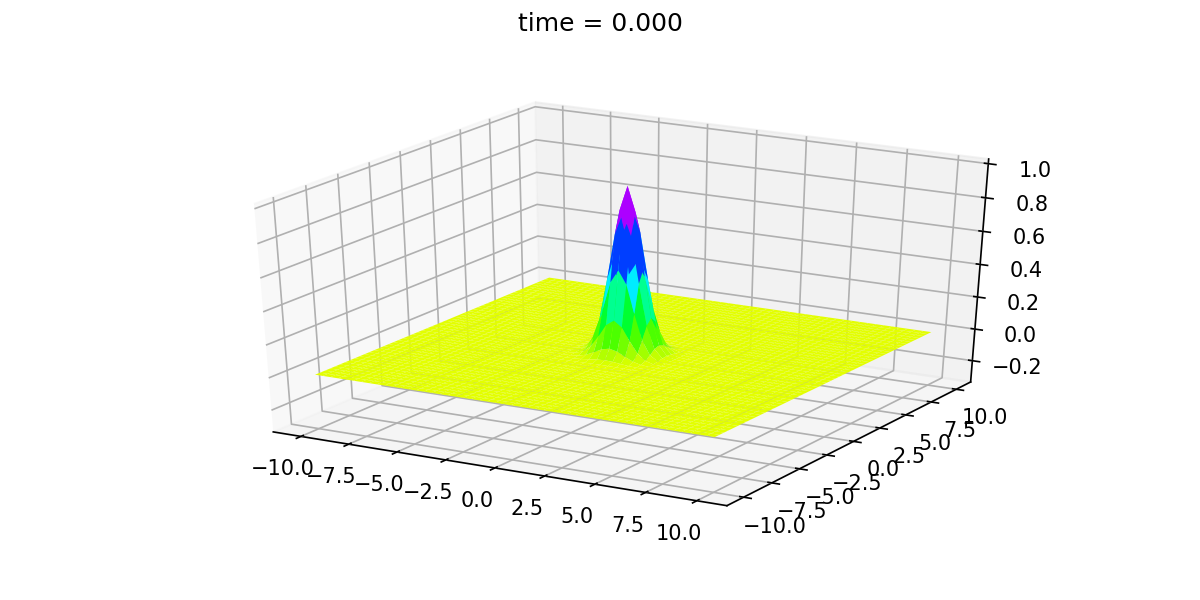

In [41]:
# set graphics backend
%matplotlib notebook
## import graphics libraries
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm

## figure properties
cmap = cm.gist_rainbow
fig_width = 8
fig_height = 4
minval = np.min(zdata)
maxval = np.max(zdata)

## choose a time step
tstep = 1

## plot
fig = plt.figure(figsize=(fig_width, fig_height))
time = time_steps[tstep]
fig.suptitle('time = %.3f' % time)
ax = fig.add_subplot(111, projection='3d')
ax.set_zlim(minval, maxval)
xi = xdata
yi = ydata
zi = zdata[tstep,:,:]
ax.plot_surface(xi, yi, zi, cstride=1, rstride=1, cmap=cmap, clim=(minval, maxval))
plt.show()

Put all time steps together into an animation using matplotlib's `animation.FuncAnimation()` command.

In [42]:
## set graphics backend
%matplotlib notebook
## import graphics libraries
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm
import matplotlib.animation as animation

## figure properties
cmap = cm.gist_rainbow
fig_width = 8
fig_height = 4
minval = np.min(zdata)
maxval = np.max(zdata)

## initialize plot
plt.ioff()
fig = plt.figure(figsize=(fig_width, fig_height))
time = time_steps[0]
fig.suptitle('time = %.3f' % time)
ax = fig.add_subplot(111, projection='3d')
ax.set_zlim(minval, maxval)
xi = xdata
yi = ydata
zi = zdata[0,:,:]
scene = [ax.plot_surface(xi, yi, zi, cstride=1, rstride=1, cmap=cmap, clim=(minval, maxval))]

## update plot
def update_plot(frame_number, time_steps, xdata, ydata, zdata, scene):
    time = time_steps[frame_number]
    fig.suptitle('time = %.3f' % time)
    scene[0].remove()
    xi = xdata
    yi = ydata
    zi = zdata[frame_number,:,:]
    scene[0] = ax.plot_surface(xi, yi, zi, cstride=1, rstride=1, cmap=cmap, clim=(minval, maxval))

## make animation
fps=5
frames=np.arange(0, len(time_steps), 1)
anim = animation.FuncAnimation(
    fig, update_plot, frames, fargs=(time_steps, xdata, ydata, zdata, scene), 
    interval=1000/fps, blit=False, repeat=False)
plt.close()

## play animation
from IPython.display import HTML
HTML(anim.to_html5_video())  #playback option 1
#HTML(anim.to_jshtml())       #playback option 2

Save the animation to a file, if you like. In order to save as an `.mp4` file, you need to have the ffmpeg library installed on your machine. 

In [43]:
## save animation to file
file = 'wave_eqn'
#anim.save(file + '.mp4', writer='ffmpeg', fps=fps)      # requires ffmpeg
anim.save(file + '.gif', writer='imagemagick', fps=fps)

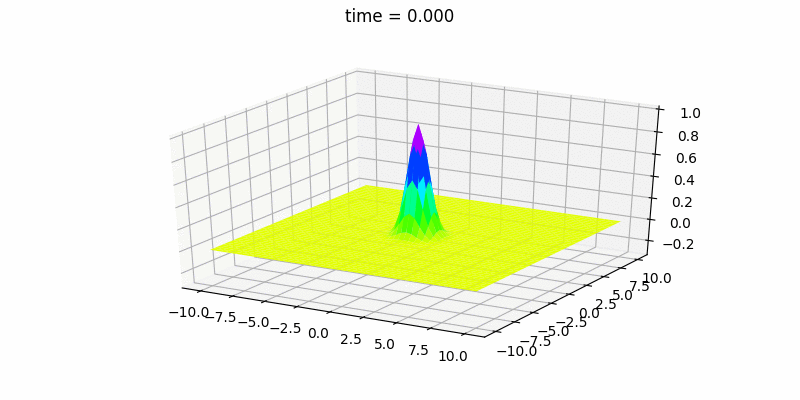

In [45]:
from IPython.display import Image
with open('wave_eqn.gif','rb') as f:
    display(Image(data=f.read(), format='gif'))

## 8. Exercises

1. Change the time stepsize and termination time of the simulation.
2. Change the grid size and grid spacing of the simulation.
3. Change the height/width/location of the initial pulse.
4. Add a wave speed parameter and run for different values.
5. Write a new function that calculates the energy of the configuration.
6. Change the boundary conditions: Dirichlet, Neumann, mixed, periodic 
7. Change the underlying equation: inviscid Burger's equation, Navier-Stokes equation 
8. Add adaptive mesh refinement using Carpet. (advanced!)

## Acknowledgments

This notebook grew out of a series of notebook-based tutorials delivered by Steve Brandt at the 2017 Einstein Toolkit school and workshop at NCSA. Those tutorials were based on his "Funwave" example--a simulation that models coastal waves. The current notebook is an attempt at a condensed version of the "create a new thorn" tutorial for new user's. To that end, the Funwave example has been replaced by a simpler case study--the standard wave equation--in order to fit everything into a single notebook. The aim has been to provide a more transparent example of how to create a new thorn from scratch. For new users, this is a daunting task, which the author of this notebook fully recognizes.

A big thanks goes to Steve Brandt for his outstanding series of Jupyter notebooks on the in's and out's of the Einstein Toolkit. His tutorials go far beyond this one, both in depth and breadth. They cover many common gotcha issues that this notebook glosses over. I would encourage any new user to work through them; it is well worth the effort to get them to work on your machine. They can be found in the Google drive [here](https://drive.google.com/drive/folders/0B4gNfWainf-5R3BldGJuRlo4dHc) and video of the 2017 workshop sessions can be found on YouTube [here](https://www.youtube.com/watch?v=jqgEaUjl23I), starting at the 4:08:37 mark.

Thanks also goes to Yosef Zlochower, whose wave equation example has been used in this notebook.

My role has basically been to merge the pedagogical clarity and thoroughness of Steve's tutorials (including his fully commented ccl file templates) with the simplicity of Yosef's example. I am fully responsible for any bugs or confusions that remain in the final result. --Eric J West